In [1]:
! unset LD_LIBRARY_PATH 

# Inference

In [ ]:
import torch
import numpy as np
import pandas as pd
import json
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lat_model_path = "../train/model/lat_cnn_lstm_model.pth"
lon_model_path = "../train/model/lon_cnn_lstm_model.pth"
csv_path = "../train/best_track_records_test.csv"
sp_json_path = "../data_preprocess/sp_data_matrix.json"
sst_json_path = "../sst_data_matrix.json"
SEQ_LEN = 8
PRED_LEN = 2
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 3e-4
L2_WEIGHT_DECAY = 1e-4
hidden_dim=256
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnn_channels=256, kernel_size=3, lstm_layers=3):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels * 2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(cnn_channels * 2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=cnn_channels * 2, out_channels=cnn_channels * 4, kernel_size=kernel_size, padding=1),
            nn.BatchNorm1d(cnn_channels * 4),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool1d(kernel_size=2)
        )

        self.lstm = nn.LSTM(input_size=cnn_channels * 4, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, PRED_LEN),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = x.transpose(1, 2)  
        x = self.cnn(x)
        x = x.transpose(1, 2)  
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]  
        output = self.fc(last_out)
        return output

lat_model = torch.load(lat_model_path, map_location=device)
lon_model = torch.load(lon_model_path, map_location=device)
lat_model.eval()
lon_model.eval()


def normalize_grid(grid):

    if np.isnan(grid).any():
        grid = fill_nan(grid)

    grid_min = np.min(grid)
    grid_max = np.max(grid)
    return (grid - grid_min) / (grid_max - grid_min)

def fill_nan(grid):

    grid = np.array(grid) 
    nan_indices = np.argwhere(np.isnan(grid)) 

    for i, j in nan_indices:
        is_boundary = (i == 0 or i == grid.shape[0] - 1 or 
                       j == 0 or j == grid.shape[1] - 1)
        if is_boundary:
            non_boundary_values = grid[1:-1, 1:-1][~np.isnan(grid[1:-1, 1:-1])]
            grid[i, j] = np.mean(non_boundary_values) if non_boundary_values.size > 0 else 0
        else:
            neighbors = grid[max(0, i-1):i+2, max(0, j-1):j+2]
            neighbors = neighbors[~np.isnan(neighbors)]
            grid[i, j] = np.mean(neighbors) if neighbors.size > 0 else 0

    return grid

def infer_typhoon_next_track(typhoon_name, csv_path, sp_json_path, sst_json_path):
    data = pd.read_csv(csv_path)
    with open(sp_json_path, 'r') as f:
        sp_data = json.load(f)
    with open(sst_json_path, 'r') as f:
        sst_data = json.load(f)
    typhoon_data = data[data['Storm Name'] == typhoon_name].copy()
    if len(typhoon_data) < 8:
        print("Error: Not enough data for the specified typhoon.")
        return
    recent_data = typhoon_data.iloc[:8]

    recent_data['Latitude_Diff'] = recent_data['Latitude (°N)'].diff().fillna(0)
    recent_data['Longitude_Diff'] = recent_data['Longitude (°E)'].diff().fillna(0)
    latitude_scaler = MinMaxScaler()
    longitude_scaler = MinMaxScaler()
    recent_data['Latitude_Diff'] = latitude_scaler.fit_transform(recent_data[['Latitude_Diff']])
    recent_data['Longitude_Diff'] = longitude_scaler.fit_transform(recent_data[['Longitude_Diff']])
    inputs = recent_data[['Latitude_Diff', 'Longitude_Diff']].values
    datetime_keys = recent_data['DateTime(UTC)'].tolist()
    sp_grids = [sp_data[f"{typhoon_name}{dt}"]['sp_grid'] for dt in datetime_keys]
    sst_grids = [sst_data[f"{typhoon_name}{dt}"]['sst_grid'] for dt in datetime_keys]
    sp_grids = np.array([normalize_grid(sp) for sp in sp_grids])
    sst_grids = np.array([normalize_grid(sst) for sst in sst_grids])
    sp_grids_flat = sp_grids.reshape(sp_grids.shape[0], -1)
    sst_grids_flat = sst_grids.reshape(sst_grids.shape[0], -1)
    inputs = np.concatenate([inputs, sp_grids_flat, sst_grids_flat], axis=1)
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)  # 添加batch维度
    with torch.no_grad():
        lat_outputs= lat_model(inputs_tensor)
        lon_outputs= lon_model(inputs_tensor)
    lat_outputs = latitude_scaler.inverse_transform(lat_outputs.cpu().numpy().reshape(-1, 1)) 
    lon_outputs = longitude_scaler.inverse_transform(lon_outputs.cpu().numpy().reshape(-1, 1)) 
    last_lat, last_lon = recent_data.iloc[-1][['Latitude (°N)', 'Longitude (°E)']]
    predicted_latitudes = last_lat + np.cumsum(lat_outputs)
    predicted_longitudes = last_lon + np.cumsum(lon_outputs)
    print(f"Typhoon: {typhoon_name}")
    print(f"Predicted Latitude Changes: {lat_outputs}")
    print(f"Predicted Longitude Changes: {lon_outputs}")
    print(f"Predicted Latitude Positions: {predicted_latitudes}")
    print(f"Predicted Longitude Positions: {predicted_longitudes}")
    return predicted_latitudes.tolist(), predicted_longitudes.tolist()
typhoon_name = "Carmen"
t, y = infer_typhoon_next_track(typhoon_name, csv_path, sp_json_path, sst_json_path)


/tmp/ipykernel_2981206/3481222963.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Latitude_Diff'] = recent_data['Latitude (°N)'].diff().fillna(0)
/tmp/ipykernel_2981206/3481222963.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Longitude_Diff'] = recent_data['Longitude (°E)'].diff().fillna(0)
/tmp/ipykernel_2981206/3481222963.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Typhoon: Carmen
Predicted Latitude Changes: [[-0.03159988]
 [-0.03103261]]
Predicted Longitude Changes: [[-0.67589206]
 [-0.6820277 ]]
Predicted Latitude Positions: [11.6684   11.637367]
Predicted Longitude Positions: [122.62411  121.942085]


# Visualization

In [ ]:
import pandas as pd

def process_storm_data(input_csv, output_csv, output_ori, predicted_latitudes, predicted_longitudes):
    """
    Reads a CSV file, extracts specific columns, and appends predicted latitudes and longitudes.
    
    Parameters:
        input_csv (str): Path to the input CSV file.
        output_csv (str): Path to save the processed CSV file.
        output_ori (str): Path to save the original extracted CSV file.
        predicted_latitudes (list[float]): Predicted latitude values to append.
        predicted_longitudes (list[float]): Predicted longitude values to append.
    """
    # Read the CSV file
    df = pd.read_csv(input_csv).head(8)
    df_ori = pd.read_csv(input_csv).head(10)
    
    # Extract required columns
    columns_to_keep = ['Storm Name', 'Latitude (°N)', 'Longitude (°E)']
    if not all(col in df.columns for col in columns_to_keep):
        raise ValueError(f"One or more required columns {columns_to_keep} are missing in the input CSV.")
    
    extracted_df = df[columns_to_keep].copy()
    extracted_df_ori = df_ori[columns_to_keep].copy()
    
    # Ensure predicted data has the same length
    if len(predicted_latitudes) != len(predicted_longitudes):
        raise ValueError("Predicted latitudes and longitudes must have the same length.")
    
    # Create a DataFrame for predicted data
    predicted_data = pd.DataFrame({
        'Storm Name': extracted_df['Storm Name'][0],
        'Latitude (°N)': predicted_latitudes,
        'Longitude (°E)': predicted_longitudes
    })
    
    # Append predicted data using pd.concat
    updated_df = pd.concat([extracted_df, predicted_data], ignore_index=True)
    
    # Save the updated DataFrame to a new CSV file
    updated_df.to_csv(output_csv, index=False)
    print(f"Processed data saved to {output_csv}")
    
    # Save the original extracted data to another CSV file
    extracted_df_ori.to_csv(output_ori, index=False)
    print(f"Processed data saved to {output_ori}")

# Example usage
input_csv_path = '../train/best_track_records_test.csv'
output_csv_path = '../inference/predicted_typhoon_path.csv'
output_ori_path = '../inference/original_typhoon_path.csv'
typhoon_name = "Carmen"
csv_path = "../train/best_track_records_test.csv"
sp_json_path = "../data_preprocess/sp_data_matrix.json"
sst_json_path = "../data_preprocess/sst_data_matrix.json"

# Assuming infer_typhoon_next_track is a function that returns predicted_latitudes and predicted_longitudes
predicted_latitudes, predicted_longitudes = infer_typhoon_next_track(typhoon_name, csv_path, sp_json_path, sst_json_path)
process_storm_data(input_csv_path, output_csv_path, output_ori_path, predicted_latitudes, predicted_longitudes)



Typhoon: Carmen
Predicted Latitude Changes: [[-0.03159988]
 [-0.03103261]]
Predicted Longitude Changes: [[-0.67589206]
 [-0.6820277 ]]
Predicted Latitude Positions: [11.6684   11.637367]
Predicted Longitude Positions: [122.62411  121.942085]
Processed data saved to /data1/dl392/yiwei/typhoon/inference/predicted_typhoon_path.csv
Processed data saved to /data1/dl392/yiwei/typhoon/inference/original_typhoon_path.csv


/tmp/ipykernel_2981206/3481222963.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Latitude_Diff'] = recent_data['Latitude (°N)'].diff().fillna(0)
/tmp/ipykernel_2981206/3481222963.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Longitude_Diff'] = recent_data['Longitude (°E)'].diff().fillna(0)
/tmp/ipykernel_2981206/3481222963.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


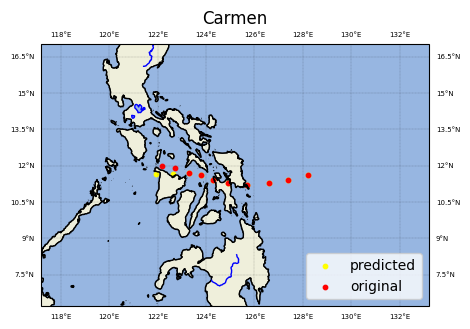

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 读取CSV文件并提取经纬度列
def plot_coordinates_on_map(csv_file, csv_file1, lat_col='Latitude (°N)', lon_col='Longitude (°E)'):
    data = pd.read_csv(csv_file)
    data1 = pd.read_csv(csv_file1)
    lats = data[lat_col]
    lons = data[lon_col]
    lats1 = data1[lat_col]
    lons1 = data1[lon_col]
    min_lat, max_lat = lats.min(), lats.max()
    min_lon, max_lon = lons.min(), lons.max()
    min_lat -= 5
    max_lat += 5
    min_lon -= 5
    max_lon += 5
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(5, 5))
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='k', alpha=0.5, linestyle='--')
    gl.xlabel_style={'size':5}
    gl.ylabel_style={'size':5}
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, edgecolor='blue')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    ax.add_feature(cfeature.OCEAN)
    ax.scatter(lons1, lats1, color='yellow', s=10, transform=ccrs.PlateCarree(), label='predicted')
    ax.scatter(lons, lats, color='red', s=10, transform=ccrs.PlateCarree(), label='original')
    ax.legend(loc='lower right')

    plt.title("Carmen")
    plt.savefig('Carmen.png')

ori_csv_file_path = "../inference/original_typhoon_path.csv"  
pre_csv_file_path = "../inference/predicted_typhoon_path.csv"
plot_coordinates_on_map(ori_csv_file_path, pre_csv_file_path, lat_col='Latitude (°N)', lon_col='Longitude (°E)')
